<a href="https://colab.research.google.com/github/harinikannan2811-pixel/Harini/blob/main/new_prjct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip -q install keras-tuner shap


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers
import keras_tuner as kt


In [32]:
np.random.seed(42)

n_obs = 1200
time = np.arange(n_obs)

data = pd.DataFrame({
    "trend": time * 0.01,
    "seasonal": np.sin(2 * np.pi * time / 50),
    "feature_1": np.random.normal(0, 1, n_obs),
    "feature_2": np.random.normal(0, 1, n_obs),
    "feature_3": np.random.normal(0, 1, n_obs)
})

# Interacting target
data["target"] = (
    0.5 * data["trend"]
    + 2 * data["seasonal"]
    + 0.3 * data["feature_1"]
    - 0.2 * data["feature_2"]
    + 0.15 * data["feature_3"] * data["seasonal"]
    + np.random.normal(0, 0.5, n_obs)
)

data.head()


,trend,seasonal,feature_1,feature_2,feature_3,target
0,0.00,0.000000,0.496714,0.125225,-0.721738,-0.287998
1,0.01,0.125333,-0.138264,-0.429406,0.176821,-0.056162
2,0.02,0.248690,0.647689,0.122298,-0.546680,1.681740
3,0.03,0.368125,1.523030,0.543298,-0.271655,1.084839
4,0.04,0.481754,-0.234153,0.048860,1.673452,1.415483


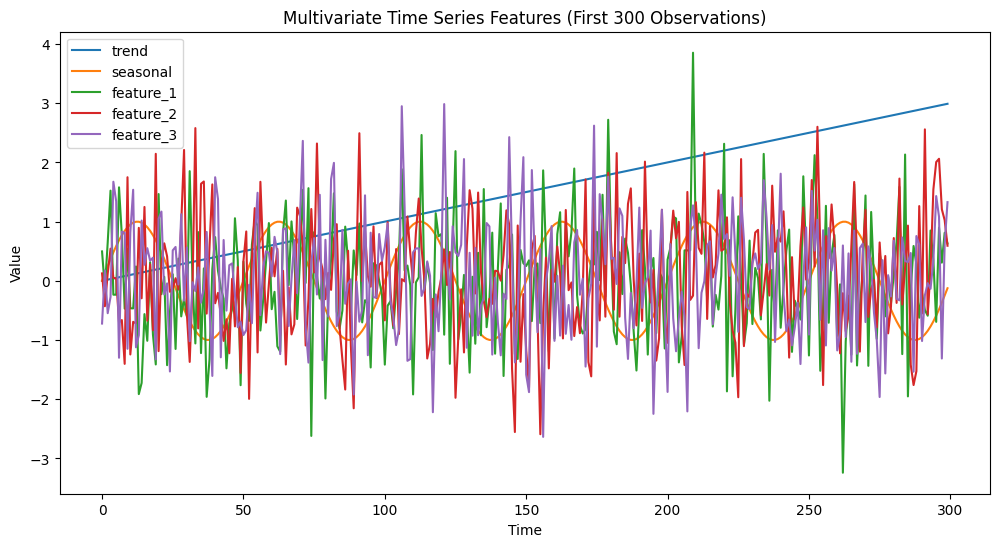

In [33]:
data[["trend", "seasonal", "feature_1", "feature_2", "feature_3"]].iloc[:300].plot(
    figsize=(12, 6),
    title="Multivariate Time Series Features (First 300 Observations)"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


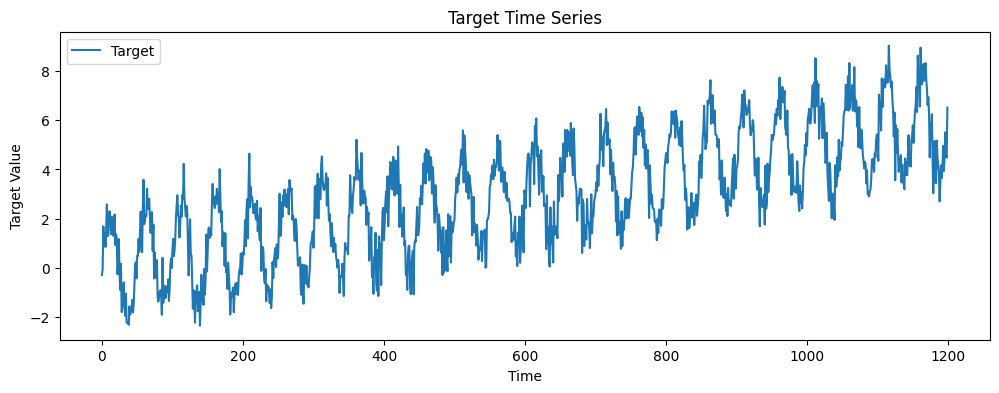

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(data["target"], label="Target")
plt.title("Target Time Series")
plt.xlabel("Time")
plt.ylabel("Target Value")
plt.legend()
plt.show()


In [35]:
features = data.drop(columns=["target"])
target = data["target"]

# Differencing
features_diff = features.diff().dropna()
target_diff = target.diff().dropna()

# Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(features_diff)
y_scaled = scaler_y.fit_transform(target_diff.values.reshape(-1, 1))


In [36]:
def create_sequences(X, y, window=20, horizon=3):
    Xs, ys = [], []
    for i in range(len(X) - window - horizon):
        Xs.append(X[i:i+window])
        ys.append(y[i+window:i+window+horizon].flatten())
    return np.array(Xs), np.array(ys)

WINDOW = 20
HORIZON = 3

X_seq, y_seq = create_sequences(X_scaled, y_scaled, WINDOW, HORIZON)

print("X_seq shape:", X_seq.shape)  # (samples, window, features)
print("y_seq shape:", y_seq.shape)  # (samples, horizon)


X_seq shape: (1176, 20, 5)
y_seq shape: (1176, 3)


In [37]:
split = int(0.8 * len(X_seq))

X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

print("Train samples:", len(X_train))
print("Val samples:", len(X_val))


Train samples: 940
Val samples: 236


In [38]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(
        layers.LSTM(
            units=hp.Int("units", min_value=32, max_value=128, step=32),
            input_shape=(WINDOW, X_seq.shape[2])
        )
    )
    model.add(layers.Dense(HORIZON))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling="log")
        ),
        loss="mse"
    )
    return model


tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,
    directory="tuning_dir",
    project_name="lstm_forecast"
)

tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    verbose=1
)


Reloading Tuner from tuning_dir/lstm_forecast/tuner0.json


In [39]:
best_hp = tuner.get_best_hyperparameters(1)[0]

best_model = tf.keras.Sequential([
    layers.LSTM(best_hp.get("units"), input_shape=(WINDOW, X_seq.shape[2])),
    layers.Dense(HORIZON)
])

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get("lr")),
    loss="mse"
)

history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0841 - val_loss: 0.0311
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0269 - val_loss: 0.0302
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0279 - val_loss: 0.0297
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0256 - val_loss: 0.0303
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0276 - val_loss: 0.0295
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0257 - val_loss: 0.0291
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0277 - val_loss: 0.0292
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0268 - val_loss: 0.0289
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0261 - val_loss: 0.0294
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0261 - val_loss: 0.0293
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0268 - val_loss: 0.0312
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0275 - val_l

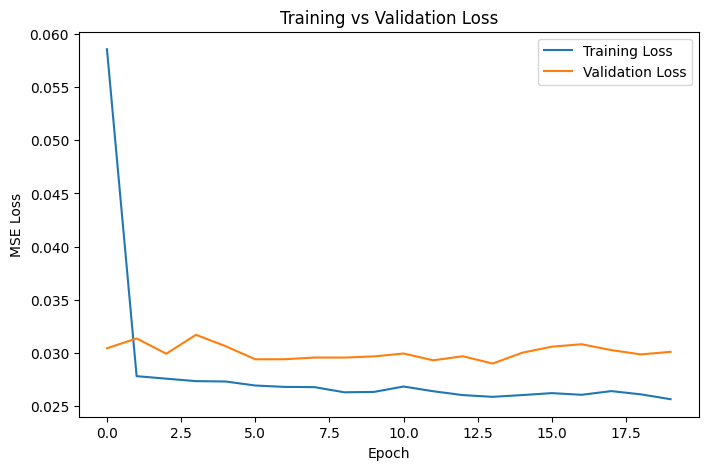

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [40]:
preds = best_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val.flatten(), preds.flatten()))
mae = mean_absolute_error(y_val.flatten(), preds.flatten())

# Safe MAPE (avoid divide-by-zero)
mape = np.mean(np.abs((y_val - preds) / (y_val + 1e-8))) * 100

print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
RMSE: 0.1720391407455354
MAE : 0.13583321452602032
MAPE: 18335660.67959232


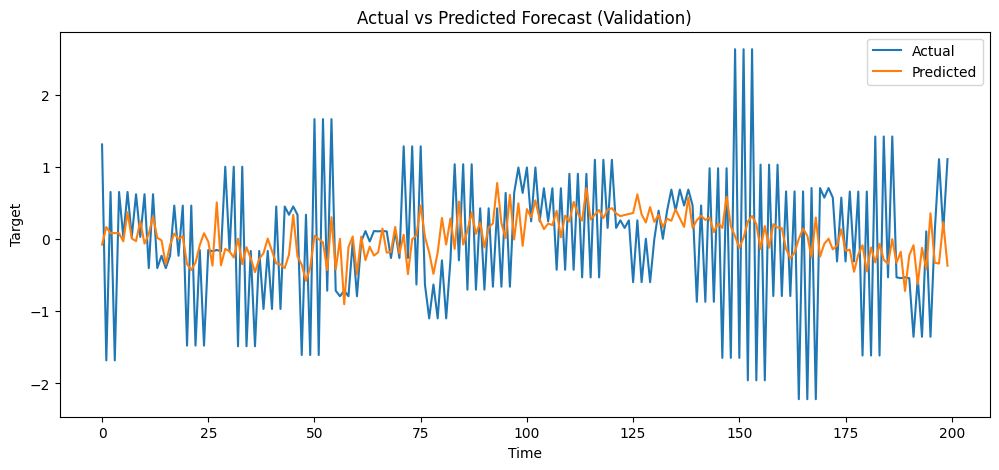

In [41]:
y_val_inv = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
preds_inv = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_val_inv[:200], label="Actual")
plt.plot(preds_inv[:200], label="Predicted")
plt.title("Actual vs Predicted Forecast (Validation)")
plt.xlabel("Time")
plt.ylabel("Target")
plt.legend()
plt.show()


In [42]:
import shap


In [43]:
def model_wrapper(x):
    x = x.reshape(-1, WINDOW, X_seq.shape[2])
    return best_model.predict(x)


In [44]:
X_train_flat = X_train[:50].reshape(50, -1)
X_val_flat = X_val[:10].reshape(10, -1)

print("X_train_flat shape:", X_train_flat.shape)
print("X_val_flat shape:", X_val_flat.shape)


X_train_flat shape: (50, 100)
X_val_flat shape: (10, 100)


In [45]:
explainer = shap.KernelExplainer(model_wrapper, X_train_flat)
shap_values = explainer.shap_values(X_val_flat)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step


/tmp/ipython-input-4070878549.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy glo

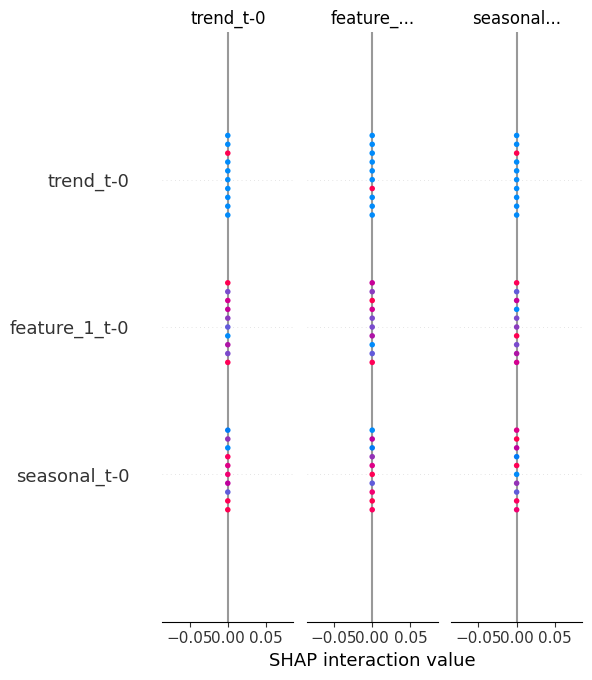

In [46]:
feature_names = [
    f"{f}_t-{i}"
    for i in range(WINDOW)
    for f in features.columns
]

shap.summary_plot(
    shap_values,
    X_val_flat,
    feature_names=feature_names
)
